# Training a CNN model on MNIST

### Install dependencies

In [1]:
%pip install matplotlib seaborn torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Dependencies
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # this import just makes the plots prettier
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

Select device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Data
Collect the MNIST dataset

In [4]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Show example images from the dataset

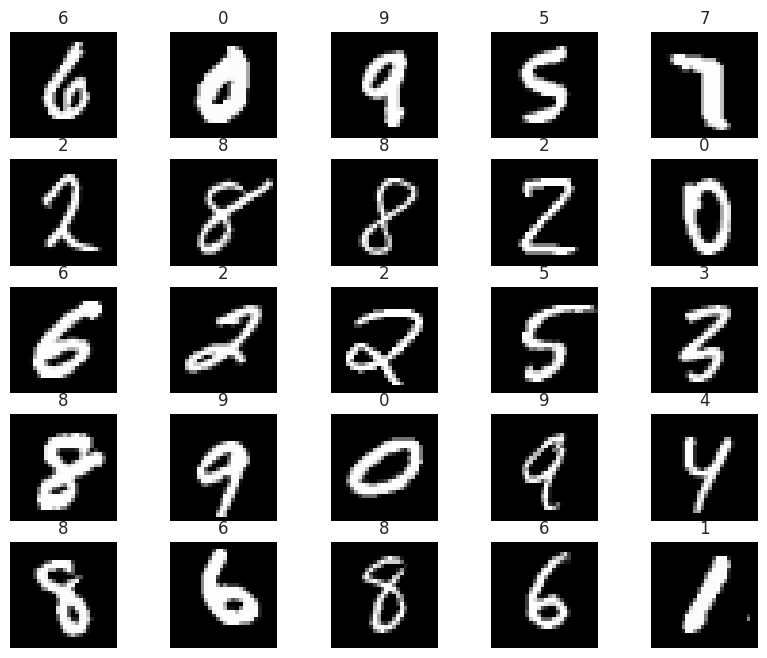

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Create data loaders

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=100, shuffle=True, num_workers=1
)

test_loader = (
    torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
)

Create a classifier model

In [7]:
class MnistClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.body = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(32 * 7 * 7, 10),
        )

    def forward(self, x):
        output = self.body(x)
        return output

In [8]:
model = MnistClassifier()
model

MnistClassifier(
  (body): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=10, bias=True)
  )
)

Create a loss function and an optimizer

In [9]:
learning_rate = 0.01

loss_func = torch.nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train the model

In [10]:
def train(num_epochs):

    model.train()

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        # For each batch in the training data
        for i, (images, labels) in enumerate(train_loader):

            # Compute output and loss
            output = model(images)
            loss = loss_func(output, labels)

            # Clear gradients for this training step
            optimizer.zero_grad()

            # Compute gradients
            loss.backward()
            # Apply gradients
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )
    
    print("Done.")

train(10)

Epoch [1/10], Step [100/600], Loss: 0.1745
Epoch [1/10], Step [200/600], Loss: 0.1889
Epoch [1/10], Step [300/600], Loss: 0.1036
Epoch [1/10], Step [400/600], Loss: 0.0367
Epoch [1/10], Step [500/600], Loss: 0.0271
Epoch [1/10], Step [600/600], Loss: 0.0403
Epoch [2/10], Step [100/600], Loss: 0.0551
Epoch [2/10], Step [200/600], Loss: 0.0739
Epoch [2/10], Step [300/600], Loss: 0.1821
Epoch [2/10], Step [400/600], Loss: 0.0600
Epoch [2/10], Step [500/600], Loss: 0.0459
Epoch [2/10], Step [600/600], Loss: 0.0104
Epoch [3/10], Step [100/600], Loss: 0.0298
Epoch [3/10], Step [200/600], Loss: 0.0615
Epoch [3/10], Step [300/600], Loss: 0.0094
Epoch [3/10], Step [400/600], Loss: 0.0300
Epoch [3/10], Step [500/600], Loss: 0.0104
Epoch [3/10], Step [600/600], Loss: 0.0327
Epoch [4/10], Step [100/600], Loss: 0.0284
Epoch [4/10], Step [200/600], Loss: 0.1323
Epoch [4/10], Step [300/600], Loss: 0.0867
Epoch [4/10], Step [400/600], Loss: 0.0420
Epoch [4/10], Step [500/600], Loss: 0.0125
Epoch [4/10

Now test the trained model

In [14]:
def test():
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)
        
        accuracy = correct / float(total)
        print('Test Accuracy of the model on the 10000 test images: %.2f%%' % (accuracy * 100))
test()

Test Accuracy of the model on the 10000 test images: 98.48%
